In [3]:
#view all dataframe
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

library(corrplot)

---
### data import

In [4]:
clinical1 <- read.csv("data.csv", header = TRUE)
head(clinical1)

bcr.patient.barcode,yearstobirth,vitalstatus,daystodeath,daystolastfollowup,tumortissuesite,pathologicstage,pathologyTstage,pathologyNstage,pathologyMstage,gender,histologicaltype,extrathyroidalextension,residualtumor,numberoflymphnodes,multifocality,tumorsize,race,ethnicity,name,days,age.group,BRAF
TCGA.BJ.A0YZ,65,0,NA,754,thyroid,stage ii,t2,n0,m0,male,thyroid papillary carcinoma . classical/usual,none,r0,NA,unifocal,NA,white,not hispanic or latino,TCGA.BJ.A0YZ.01A,754,60.69,0
TCGA.BJ.A0Z0,55,0,NA,419,thyroid,stage ii,t2,n0,mx,male,thyroid papillary carcinoma . classical/usual,none,r0,0,unifocal,NA,NA,not hispanic or latino,TCGA.BJ.A0Z0.01A,419,50.59,0
TCGA.BJ.A0Z2,57,0,NA,1514,thyroid,stage ivc,t2,n0,m1,male,thyroid papillary carcinoma . follicular (>= 99% follicular patterned),none,rx,NA,unifocal,2.8,black or african american,not hispanic or latino,TCGA.BJ.A0Z2.01A,1514,50.59,0
TCGA.BJ.A0Z3,33,0,NA,497,thyroid,stage i,t1,n0,m0,female,thyroid papillary carcinoma . classical/usual,none,rx,0,multifocal,1.3,white,not hispanic or latino,TCGA.BJ.A0Z3.01A,497,30.39,1
TCGA.BJ.A0Z5,58,0,NA,448,thyroid,stage iii,t3,n1a,m0,male,thyroid papillary carcinoma . classical/usual,NA,NA,4,NA,NA,white,not hispanic or latino,TCGA.BJ.A0Z5.01A,448,50.59,0
TCGA.BJ.A0Z9,57,0,NA,1257,thyroid,stage iii,t3,n0,mx,female,thyroid papillary carcinoma . tall cell (>= 50% tall cell features),minimal (t3),r1,0,multifocal,2.8,white,not hispanic or latino,TCGA.BJ.A0Z9.01A,1257,50.59,1


In [5]:
clinical2 <- clinical1[, c("multifocality", "BRAF", "name")]
clinical2$name <- substr(clinical1$name, 1, 15)
clinical2$key <- row.names(clinical1)
head(clinical2)

multifocality,BRAF,name,key
unifocal,0,TCGA.BJ.A0YZ.01,1
unifocal,0,TCGA.BJ.A0Z0.01,2
unifocal,0,TCGA.BJ.A0Z2.01,3
multifocal,1,TCGA.BJ.A0Z3.01,4
NA,0,TCGA.BJ.A0Z5.01,5
multifocal,1,TCGA.BJ.A0Z9.01,6


In [6]:
# converting focality

clinical2$focality <- as.character(clinical1$multifocality)
clinical2$focality[clinical1$multifocality == "multifocal"] <- 1
clinical2$focality[clinical1$multifocality == "unifocal"] <- 0
clinical2$focality <- as.numeric(clinical2$focality)

In [7]:
head(clinical2)

multifocality,BRAF,name,key,focality
unifocal,0,TCGA.BJ.A0YZ.01,1,0
unifocal,0,TCGA.BJ.A0Z0.01,2,0
unifocal,0,TCGA.BJ.A0Z2.01,3,0
multifocal,1,TCGA.BJ.A0Z3.01,4,1
NA,0,TCGA.BJ.A0Z5.01,5,NA
multifocal,1,TCGA.BJ.A0Z9.01,6,1


In [8]:
#separate BRAF/focality

clinical_p <- clinical2[clinical2$BRAF %in% "1",]
head(clinical_p)

clinical_p_uni <- clinical_p[clinical_p$focality %in% "0",]
head(clinical_p_uni)

clinical_p_multi <- clinical_p[clinical_p$focality %in% "1",]
head(clinical_p_multi)

,multifocality,BRAF,name,key,focality
4,multifocal,1,TCGA.BJ.A0Z3.01,4,1
6,multifocal,1,TCGA.BJ.A0Z9.01,6,1
8,unifocal,1,TCGA.BJ.A0ZB.01,8,0
12,NA,1,TCGA.BJ.A0ZH.01,12,NA
15,multifocal,1,TCGA.BJ.A18Z.01,15,1
19,unifocal,1,TCGA.BJ.A28R.01,19,0


,multifocality,BRAF,name,key,focality
8,unifocal,1,TCGA.BJ.A0ZB.01,8,0
19,unifocal,1,TCGA.BJ.A28R.01,19,0
26,unifocal,1,TCGA.BJ.A290.01,26,0
35,unifocal,1,TCGA.BJ.A3PR.01,35,0
37,unifocal,1,TCGA.BJ.A3PU.01,37,0
48,unifocal,1,TCGA.BJ.A4O9.01,48,0


,multifocality,BRAF,name,key,focality
4,multifocal,1,TCGA.BJ.A0Z3.01,4,1
6,multifocal,1,TCGA.BJ.A0Z9.01,6,1
15,multifocal,1,TCGA.BJ.A18Z.01,15,1
20,multifocal,1,TCGA.BJ.A28S.01,20,1
24,multifocal,1,TCGA.BJ.A28X.01,24,1
31,multifocal,1,TCGA.BJ.A2NA.01,31,1


In [9]:
nrow(clinical_p_uni)

[1] 127

---
### loading mRNA

In [10]:
load("mRNA.RData")

In [11]:
#miRNA df name col 분리
name <- rownames(mRNA)
rownames(mRNA) <- NULL
mRNA <- cbind(name,mRNA)

In [12]:
head(mRNA)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt'의 길이가 최대 포맷길이 8192를 초과합니다

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.data.frame(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(wrap, header, bod

name,A1BG,A2BP1,A2LD1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB10,ABCB1,ABCB4,ABCB6,ABCB7,ABCB8,ABCB9,ABCC10,ABCC11,ABCC1,ABCC2,ABCC3,ABCC4,ABCC5,ABCC6P1,ABCC6P2,ABCC6,ABCC8,ABCC9,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,ABCF1,ABCF2,ABCF3,ABCG1,ABCG2,ABCG4,ABCG5,ABHD10,ABHD11,ABHD12B,ABHD12,ABHD13,ABHD14A,ABHD14B,ABHD15,ABHD1,ABHD2,ABHD3,ABHD4,ABHD5,ABHD6,ABHD8,ABI1,ABI2,ABI3BP,ABI3,ABL1,ABL2,ABLIM1,ABLIM2,ABLIM3,ABO,ABP1,ABR,ABT1,ABTB1,ABTB2,ACAA1,ACAA2,...,ZNF791,ZNF792,ZNF793,ZNF799,ZNF79,ZNF7,ZNF800,ZNF804A,ZNF805,ZNF808,ZNF80,ZNF813,ZNF814,ZNF815,ZNF816A,ZNF81,ZNF821,ZNF823,ZNF826,ZNF827,ZNF828,ZNF829,ZNF830,ZNF831,ZNF833,ZNF835,ZNF836,ZNF837,ZNF839,ZNF83,ZNF841,ZNF843,ZNF844,ZNF845,ZNF846,ZNF84,ZNF853,ZNF85,ZNF860,ZNF862,ZNF876P,ZNF878,ZNF879,ZNF880,ZNF883,ZNF8,ZNF90,ZNF91,ZNF92,ZNF93,ZNF98,ZNFX1,ZNHIT1,ZNHIT2,ZNHIT3,ZNHIT6,ZNRD1,ZNRF1,ZNRF2,ZNRF3,ZP1,ZP3,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
TCGA-4C-A93U-01A-11R-A39I-07,108.7681,0.0000,80.1401,13369.058,256.0386,1.9324,665.7005,371.0145,144.9275,736.7150,842.5121,2551.208,0.4831,483.9903,571.4976,3375.362,605.7971,184.0580,288.4058,1251.6908,50.7246,1688.406,3.3816,117.6763,27.5362,417.3913,12.0773,641.0628,1648.309,3061.836,29.9517,198.5507,13.0435,901.4493,19.8068,6.2802,405.3140,40.5797,11.5942,129.0580,487.4396,688.8889,129.4734,500.4831,0.0000,1368.599,0.4831,3239.6135,72.4638,185.5072,68.1159,86.9565,201.9324,0.0000,200.4831,257.0048,13.5266,1271.981,779.2271,1054.5894,1430.435,1170.5314,946.8599,674.8792,128.5024,2.8986,0.4831,772.9469,1012.0773,4.8309,2882.126,478.7440,731.8841,1998.068,261.3527,1.9324,1901.449,526.0870,1300.9662,498.0676,111.5942,545.8937,1197.0531,2698.551,1850.7246,232.8502,1544.928,1018.3575,2293.720,169.0821,82.1256,67.6329,6.7633,2303.8647,436.2319,616.4251,484.0580,1277.778,1811.1111,...,236.2319,116.9082,77.2947,58.9372,29.9517,422.3575,260.3865,4.3478,213.5266,181.1594,5.7198,40.0966,169.8647,16.4251,82.0966,71.0145,183.4396,34.7826,20.7729,247.8261,323.6715,8.2126,289.3720,33.8164,0.9662,21.2560,84.0580,57.9710,364.2512,753.6232,198.5507,5.7971,151.6908,81.6425,62.8019,494.2029,264.2512,73.9130,136.7150,259.4203,27.5362,2.8986,40.0966,98.5507,14.9758,116.0193,157.4879,285.0242,76.8116,31.4010,0.4831,2190.821,1131.401,197.1014,428.6957,493.2367,375.5845,731.8841,1414.9758,417.3913,0.9662,34.9420,0.4831,749.2754,1241.8019,49.2754,355.5556,12.4734,68.1159,95.6522,1825.121,0.9662,47.3430,83.1159,52.6570,40.5797,268.1159,134.2995,87.4396,28.9855,0.9662,149.2754,34.2995,444.9275,329.4686,240.0966,289.1401,112.5604,287.4396,144.5604,194.6860,67.6329,253.1401,865.7005,26.0870,1799.0338,4436.2319,869.0821,655.5556,48.3092
TCGA-BJ-A0YZ-01A-11R-A10U-07,251.7201,23.7401,64.3773,20192.378,286.1308,5.8309,622.2407,949.1878,112.8696,1657.6426,2230.7372,3315.285,2.0825,407.3303,867.5552,5159.100,748.0217,211.9950,294.0441,1120.7830,57.8925,3378.592,1.6660,110.4581,3.3319,3.3319,10.4123,965.4144,2717.618,2174.094,127.8634,241.5660,18.7422,481.0496,74.9688,4.1649,248.6464,209.0796,33.3195,512.4906,446.0641,726.7805,72.2282,409.4127,6.6639,2091.212,0.8330,1430.2374,117.4511,179.9250,0.0000,44.1483,47.0637,2.4990,692.2116,329.0296,2.0825,2283.632,1020.4082,900.8746,1491.462,1114.5356,1078.7172,303.2070,760.1000,64.1399,0.4165,940.0250,1123.2820,9.9958,4539.775,330.2791,2467.1179,5574.761,1105.3728,43.7318,1610.579,528.1133,2873.3861,1429.8209,862.9738,503.9567,900.2624,2020.825,23.7401,519.3669,2488.963,551.4369,6556.018,136.6097,222.8238,600.1666,0.8330,1192.8363,469.3878,362.3490,30.4040,10713.869,4476.4681,...,249.8959,106.2057,130.7788,98.2924,183.2570,278.8338,298.6256,2.9155,243.

In [13]:
#mRNA name 형식 변경
#TCGA-DJ-A2Q5-01A-11R-A18B-13 type >>> TCGA.BJ.A0YZ.01 type(clinical2)
mRNA$name <- gsub("-", ".", mRNA$name)
mRNA$name <- substr(mRNA$name, 1, 15)

In [14]:
head(mRNA)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt'의 길이가 최대 포맷길이 8192를 초과합니다

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.data.frame(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(wrap, header, bod

name,A1BG,A2BP1,A2LD1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB10,ABCB1,ABCB4,ABCB6,ABCB7,ABCB8,ABCB9,ABCC10,ABCC11,ABCC1,ABCC2,ABCC3,ABCC4,ABCC5,ABCC6P1,ABCC6P2,ABCC6,ABCC8,ABCC9,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,ABCF1,ABCF2,ABCF3,ABCG1,ABCG2,ABCG4,ABCG5,ABHD10,ABHD11,ABHD12B,ABHD12,ABHD13,ABHD14A,ABHD14B,ABHD15,ABHD1,ABHD2,ABHD3,ABHD4,ABHD5,ABHD6,ABHD8,ABI1,ABI2,ABI3BP,ABI3,ABL1,ABL2,ABLIM1,ABLIM2,ABLIM3,ABO,ABP1,ABR,ABT1,ABTB1,ABTB2,ACAA1,ACAA2,...,ZNF791,ZNF792,ZNF793,ZNF799,ZNF79,ZNF7,ZNF800,ZNF804A,ZNF805,ZNF808,ZNF80,ZNF813,ZNF814,ZNF815,ZNF816A,ZNF81,ZNF821,ZNF823,ZNF826,ZNF827,ZNF828,ZNF829,ZNF830,ZNF831,ZNF833,ZNF835,ZNF836,ZNF837,ZNF839,ZNF83,ZNF841,ZNF843,ZNF844,ZNF845,ZNF846,ZNF84,ZNF853,ZNF85,ZNF860,ZNF862,ZNF876P,ZNF878,ZNF879,ZNF880,ZNF883,ZNF8,ZNF90,ZNF91,ZNF92,ZNF93,ZNF98,ZNFX1,ZNHIT1,ZNHIT2,ZNHIT3,ZNHIT6,ZNRD1,ZNRF1,ZNRF2,ZNRF3,ZP1,ZP3,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22
TCGA.4C.A93U.01,108.7681,0.0000,80.1401,13369.058,256.0386,1.9324,665.7005,371.0145,144.9275,736.7150,842.5121,2551.208,0.4831,483.9903,571.4976,3375.362,605.7971,184.0580,288.4058,1251.6908,50.7246,1688.406,3.3816,117.6763,27.5362,417.3913,12.0773,641.0628,1648.309,3061.836,29.9517,198.5507,13.0435,901.4493,19.8068,6.2802,405.3140,40.5797,11.5942,129.0580,487.4396,688.8889,129.4734,500.4831,0.0000,1368.599,0.4831,3239.6135,72.4638,185.5072,68.1159,86.9565,201.9324,0.0000,200.4831,257.0048,13.5266,1271.981,779.2271,1054.5894,1430.435,1170.5314,946.8599,674.8792,128.5024,2.8986,0.4831,772.9469,1012.0773,4.8309,2882.126,478.7440,731.8841,1998.068,261.3527,1.9324,1901.449,526.0870,1300.9662,498.0676,111.5942,545.8937,1197.0531,2698.551,1850.7246,232.8502,1544.928,1018.3575,2293.720,169.0821,82.1256,67.6329,6.7633,2303.8647,436.2319,616.4251,484.0580,1277.778,1811.1111,...,236.2319,116.9082,77.2947,58.9372,29.9517,422.3575,260.3865,4.3478,213.5266,181.1594,5.7198,40.0966,169.8647,16.4251,82.0966,71.0145,183.4396,34.7826,20.7729,247.8261,323.6715,8.2126,289.3720,33.8164,0.9662,21.2560,84.0580,57.9710,364.2512,753.6232,198.5507,5.7971,151.6908,81.6425,62.8019,494.2029,264.2512,73.9130,136.7150,259.4203,27.5362,2.8986,40.0966,98.5507,14.9758,116.0193,157.4879,285.0242,76.8116,31.4010,0.4831,2190.821,1131.401,197.1014,428.6957,493.2367,375.5845,731.8841,1414.9758,417.3913,0.9662,34.9420,0.4831,749.2754,1241.8019,49.2754,355.5556,12.4734,68.1159,95.6522,1825.121,0.9662,47.3430,83.1159,52.6570,40.5797,268.1159,134.2995,87.4396,28.9855,0.9662,149.2754,34.2995,444.9275,329.4686,240.0966,289.1401,112.5604,287.4396,144.5604,194.6860,67.6329,253.1401,865.7005,26.0870,1799.0338,4436.2319,869.0821,655.5556,48.3092
TCGA.BJ.A0YZ.01,251.7201,23.7401,64.3773,20192.378,286.1308,5.8309,622.2407,949.1878,112.8696,1657.6426,2230.7372,3315.285,2.0825,407.3303,867.5552,5159.100,748.0217,211.9950,294.0441,1120.7830,57.8925,3378.592,1.6660,110.4581,3.3319,3.3319,10.4123,965.4144,2717.618,2174.094,127.8634,241.5660,18.7422,481.0496,74.9688,4.1649,248.6464,209.0796,33.3195,512.4906,446.0641,726.7805,72.2282,409.4127,6.6639,2091.212,0.8330,1430.2374,117.4511,179.9250,0.0000,44.1483,47.0637,2.4990,692.2116,329.0296,2.0825,2283.632,1020.4082,900.8746,1491.462,1114.5356,1078.7172,303.2070,760.1000,64.1399,0.4165,940.0250,1123.2820,9.9958,4539.775,330.2791,2467.1179,5574.761,1105.3728,43.7318,1610.579,528.1133,2873.3861,1429.8209,862.9738,503.9567,900.2624,2020.825,23.7401,519.3669,2488.963,551.4369,6556.018,136.6097,222.8238,600.1666,0.8330,1192.8363,469.3878,362.3490,30.4040,10713.869,4476.4681,...,249.8959,106.2057,130.7788,98.2924,183.2570,278.8338,298.6256,2.9155,243.2320,311.5369,0.0000,78.71

In [15]:
selected_mRNA = read.csv("mRNA_selected.csv")

In [16]:
head(selected_mRNA)

name,ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,ADGRL2,ADGRL4,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,C10ORF76,C15ORF56,C1ORF95,C6ORF89,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD9,CD99L2,CEP126,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GALNT16,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PDIA3P1,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PRR29,PTPRN2,QPCT,RALB,RAPGEF4,RFTN2,RGS5,RIMKLB,RMDN2,RNF146,RNF38,ROBO4,RUNDC3B,SCARF1,SCD5,SCN4A,SCNN1G,SERHL,SFTA3,SH3BGRL,SLIT3,SMG6,SPPL3,SPTLC1,ST6GALNAC6,STARD8,SULT1C4,TBC1D13,TCEAL8,TCF4,TEK,TESC,THSD7B,THUMPD1,TM4SF18,TMBIM6,TMEM204,TMEM242,TMEM248,TMEM57,TMEM59,TRIM4,TRPC4,UBL3,ZEB1,ZNF287,ZNF423,ZNF436,ZNF624,ZNF709,ZNF772
select,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [17]:
mRNA_f <- dplyr::bind_rows(mRNA, selected_mRNA)

Warning message in bind_rows_(x, .id):
"binding character and factor vector, coercing into character vector"

In [18]:
tail(mRNA_f)

ERROR while rich displaying an object: Error in sprintf(wrap, header, body): 'fmt'의 길이가 최대 포맷길이 8192를 초과합니다

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_latex.data.frame(obj)
9. repr_matrix_generic(obj, sprintf("\\begin{tabular}{%s}\n%%s%%s\\end{tabular}\n", 
 .     cols), "%s\\\\\n\\hline\n", "  &", " %s &", "%s", "\t%s\\\\\n", 
 .     "%s &", " %s &", escape_fun = latex_escape_vec, ...)
10. sprintf(wrap, header, bod

,name,A1BG,A2BP1,A2LD1,A2M,A4GALT,A4GNT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMP,AANAT,AARS2,AARSD1,AARS,AASDHPPT,AASDH,AASS,AATF,AATK,ABAT,ABCA10,ABCA11P,ABCA12,ABCA13,ABCA17P,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB10,ABCB1,ABCB4,ABCB6,ABCB7,ABCB8,ABCB9,ABCC10,ABCC11,ABCC1,ABCC2,ABCC3,ABCC4,ABCC5,ABCC6P1,ABCC6P2,ABCC6,ABCC8,ABCC9,ABCD1,ABCD2,ABCD3,ABCD4,ABCE1,ABCF1,ABCF2,ABCF3,ABCG1,ABCG2,ABCG4,ABCG5,ABHD10,ABHD11,ABHD12B,ABHD12,ABHD13,ABHD14A,ABHD14B,ABHD15,ABHD1,ABHD2,ABHD3,ABHD4,ABHD5,ABHD6,ABHD8,ABI1,ABI2,ABI3BP,ABI3,ABL1,ABL2,ABLIM1,ABLIM2,ABLIM3,ABO,ABP1,ABR,ABT1,ABTB1,ABTB2,ACAA1,ACAA2,...,ZNF815,ZNF816A,ZNF81,ZNF821,ZNF823,ZNF826,ZNF827,ZNF828,ZNF829,ZNF830,ZNF831,ZNF833,ZNF835,ZNF836,ZNF837,ZNF839,ZNF83,ZNF841,ZNF843,ZNF844,ZNF845,ZNF846,ZNF84,ZNF853,ZNF85,ZNF860,ZNF862,ZNF876P,ZNF878,ZNF879,ZNF880,ZNF883,ZNF8,ZNF90,ZNF91,ZNF92,ZNF93,ZNF98,ZNFX1,ZNHIT1,ZNHIT2,ZNHIT3,ZNHIT6,ZNRD1,ZNRF1,ZNRF2,ZNRF3,ZP1,ZP3,ZPLD1,ZRANB1,ZRANB2,ZRANB3,ZRSR2,ZSCAN12P1,ZSCAN12,ZSCAN16,ZSCAN18,ZSCAN1,ZSCAN20,ZSCAN21,ZSCAN22,ZSCAN23,ZSCAN29,ZSCAN2,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSWIM1,ZSWIM3,ZSWIM4,ZSWIM5,ZSWIM6,ZSWIM7,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,ADGRL2,ADGRL4,C10ORF76,C15ORF56,C1ORF95,C6ORF89,CEP126,GALNT16,PDIA3P1,PRR29,RMDN2,TMEM242,TMEM248
497,TCGA.MK.A4N6.01,70.8471,0.7666,96.7574,7901.100,547.7194,0.0000,446.5312,502.1081,78.1909,899.5784,1136.068,2355.692,0.0000,431.5332,410.8854,2704.868,727.4818,257.9532,190.1112,942.8900,61.7095,1670.372,2.2997,70.2645,17.6313,54.8103,3.0663,1296.6194,2723.266,2522.422,78.9575,292.4492,11.1154,504.4078,66.3089,3.8329,306.6309,32.9628,7.6658,258.7160,436.1824,642.3917,142.6984,486.7765,3.4496,1527.022,2.2997,3004.599,230.3565,175.9295,37.9456,61.7095,150.6324,0.3833,95.8222,292.0659,9.9655,1413.568,616.7114,924.4921,1398.6202,1244.9214,1085.0901,730.9314,51.3607,56.7267,0.0000,495.2089,1112.3036,1.1499,3909.927,446.9145,394.0667,1807.206,435.0326,4.2162,2281.334,1049.4442,1097.3553,845.9180,134.5343,409.7355,1947.4665,2431.583,50.9774,130.3181,4886.930,899.5784,8213.109,306.2476,211.1920,111.5370,47.1445,3118.053,415.4849,389.8045,2407.8191,1727.099,2251.821,...,18.7811,110.7512,83.5569,228.0567,84.7068,41.0119,267.5355,344.5765,11.4987,308.5473,32.5795,6.1326,6.1326,127.6351,37.5623,240.7053,832.8862,227.6734,10.7321,443.8482,128.7850,79.7240,587.5814,555.0019,86.2399,78.9575,352.6255,32.9628,1.5332,54.4270,269.0686,18.0146,95.9371,119.5860,301.2649,120.7359,74.7413,14.9483,2955.922,869.6819,161.1690,387.9801,376.7727,229.6167,1040.245,1205.4427,1101.9548,0.7666,24.9138,7.2825,1162.8977,1281.966,61.7095,230.3565,26.7689,205.0594,79.3407,2414.335,2.6830,47.1445,144.8256,80.1073,54.0437,261.0195,193.5608,1.5332,22.6140,0.3833,158.2982,59.7930,307.0142,377.1560,274.0514,266.9030,123.8022,301.2649,189.2641,184.3618,36.4124,371.7900,1043.312,62.8593,2811.422,4632.426,1179.762,718.6662,411.6520,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,TCGA.MK.A4N7.01,46.7046,1018.9109,132.6771,8726.942,174.3753,0.9114,671.0716,321.7134,232.0954,933.2422,1530.797,2793.347,0.6076,329.6058,615.1743,2436.394,1112.7820,205.9695,401.0025,1151.3633,190.4762,1559.657,5.1644,153.1070,1.5189,201.7164,29.4676,2540.8855,7213.792,1285.031,101.1620,301.3595,49.8215,426.5208,551.0747,11.2402,259.1327,33.4169,4.5568,202.9863,484.2409,620.6425,155.3915,497.0001,13.0630,1670.540,3.3417,3172.780,173.1602,132.7561,2.1265,64.0996,170.1223,4.5568,203.2354,315.6376,1.8227,1619.807,998.8608,966.6591,1036.2269,1182.0460,1064.1756,913.7997,264.9047,8.8099,0.6076,918.3565,1391.3572,1.2152,2804.587,457.2036,853.7009,2118.934,274.9297,15.1895,3053.695,525.8601,1269.2337,557.7580,170.1223,411.0276,1462.3741,3650.642,45.2647,88.4028,4657.097,565.3528,7827.447,452.0392,81.1119,186.2231,6.0758,1657.477,483.3295,487.5826,1251.9177,1807.549,3706.539,...,32.2017,120.9509,85.3649,375.3870,62.5807,13.9743,171.9450,473.9121,17.9236,389.7623,3.0379,9.4175,11.5440,120.3008,80.2005,327.1816,748.8418,227.8423,

In [31]:
for(i in 1:ncol(mRNA_f)-1){
    if(is.na(mRNA_f[502,i+1])==TRUE){
        print(1)
        mRNA_f <- mRNA_f[,-(i+1)]
    }
}

In [32]:
tail(mRNA_f)

,name,ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD99L2,CD9,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PTPRN2,QPCT,RALB,RAPGEF4,RFTN2,RGS5,RIMKLB,RNF146,RNF38,ROBO4,RUNDC3B,SCARF1,SCD5,SCN4A,SCNN1G,SERHL,SFTA3,SH3BGRL,SLIT3,SMG6,SPPL3,SPTLC1,ST6GALNAC6,STARD8,SULT1C4,TBC1D13,TCEAL8,TCF4,TEK,TESC,THSD7B,THUMPD1,TM4SF18,TMBIM6,TMEM204,TMEM57,TMEM59,TRIM4,TRPC4,UBL3,ZEB1,ZNF287,ZNF423,ZNF436,ZNF624,ZNF709,ZNF772,ADGRL2,ADGRL4,C10ORF76,C15ORF56,C1ORF95,C6ORF89,CEP126,GALNT16,PDIA3P1,PRR29,RMDN2,TMEM242,TMEM248
497,TCGA.MK.A4N6.01,1670.372,66.3089,32.9628,779.609,108.8540,551.5523,272.7635,798.7735,370.2568,89643.16,302.0314,495.2089,3083.174,140.2836,108.4707,882.7597,444.2315,236.8724,2629.360,307.0142,158.6585,5.3660,391.3377,1.9164,4835.186,599.4634,7909.544,635.8758,13537.371,505.1476,1111.920,1211.959,921.8091,180.9122,15.3315,4437.716,18.3979,1490.993,6.5159,7.6658,513.6067,1042.5450,23.3806,124.9521,1741.280,3043.695,209.2756,18.0146,1128.4017,5.3660,135.3009,357.6888,251.0540,197.3936,72.8248,111.5370,183.7754,1.9164,59.4097,918.3595,92.7558,146.0330,1261.4028,13.4151,1.9164,137.2173,1058.260,431.9663,16394.02,384.4385,2.6830,1120.3526,1033.729,11.4987,424.3005,1741.664,718.2829,466.4622,451.5140,471.0617,341.9433,172.0966,150.2491,38.3289,66.3089,1638.942,3599.847,6106.171,226.5236,18.0146,377.9226,169.4136,313.9134,57.8766,614.0284,1477.961,1490.993,602.9130,613.6451,2626.6769,1704.101,29.1299,29.8965,2922.576,612.7597,847.8344,1306.248,138.3672,10.7321,217.7079,2559.218,164.4308,69.7585,37.9456,1753.618,2629.360,1408.586,1524.339,1170.180,2376.006,1529.705,160.5979,20.6976,746.6462,1018.398,685.320,216.1748,523.5722,5.3660,828.670,17.6313,25183.21,170.9467,653.8904,7188.195,838.6355,13.0318,2160.981,378.3174,81.2572,62.4760,618.5473,58.6432,103.4879,248.3710,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
498,TCGA.MK.A4N7.01,1559.657,551.0747,33.4169,1564.517,169.2109,845.1432,471.3207,292.2458,570.5172,91345.33,512.7971,912.8883,5739.804,483.3295,293.7647,2353.3622,952.9885,267.9426,2433.964,1827.5993,513.2376,47.0874,645.8571,1.8227,7019.367,868.2312,12279.487,1099.1114,16588.441,743.9690,1087.871,1909.622,1005.5442,299.8405,37.6699,16243.336,43.7457,1531.404,24.6070,48.9102,540.7458,2054.2265,32.8093,520.0881,2757.497,2499.886,328.7005,53.7131,1506.4935,18.5312,178.3246,640.3038,360.5985,251.5379,119.6932,177.7170,576.5201,16.1009,91.4407,1288.0687,184.7042,369.7122,1566.3401,57.7201,7.5947,210.8301,3221.994,875.5221,18019.59,606.9720,65.6186,970.0008,1252.525,10.3289,535.2776,3016.329,985.7978,701.4506,580.8461,739.1205,487.5218,1308.7203,185.9193,111.7946,57.1125,2256.247,6075.796,12112.098,488.7978,262.4744,426.2171,405.2556,462.3680,81.1119,598.4659,1631.959,1617.681,3927.6980,678.3626,3301.2835,1480.368,131.8448,27.6449,7880.914,718.9124,2946.4571,1819.093,411.3314,8.2023,537.7079,4123.642,222.0703,531.0245,113.3136,4180.582,2994.152,5375.560,2347.384,1541.126,2640.845,1751.652,208.7036,27.0373,1223.9690,1181.742,1250.095,318.3717,6291.1825,25.8221,1180.831,73.2133,31316.78,290.4230,955.4189,9488.874,1119.7691,22.1767,3363.864,266.4024,194.7292,92.0483,791.6853,114.5287,171.6412,444.7482,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
499,TCGA.MK.A4N9.01,1556.532,411.9601,63.4444,5440.789,428.6786,531.5615,504.8805,1155.7175,273.9256,97369.63,798.1995,1418.9262,6733.255,434.2514,414.1035,1658.6389,488.2649,303.9331,2044.368,1685.9929,430.2861,64.3018,868.0742,2.5721,12895.081,1353.7670,12876.648,1088.4150,15142.214,662.2699

In [33]:
mRNA <- mRNA_f[1:501,1:(ncol(mRNA_f)-13)]

In [34]:
head(mRNA)

name,ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD99L2,CD9,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PTPRN2,QPCT,RALB,RAPGEF4,RFTN2,RGS5,RIMKLB,RNF146,RNF38,ROBO4,RUNDC3B,SCARF1,SCD5,SCN4A,SCNN1G,SERHL,SFTA3,SH3BGRL,SLIT3,SMG6,SPPL3,SPTLC1,ST6GALNAC6,STARD8,SULT1C4,TBC1D13,TCEAL8,TCF4,TEK,TESC,THSD7B,THUMPD1,TM4SF18,TMBIM6,TMEM204,TMEM57,TMEM59,TRIM4,TRPC4,UBL3,ZEB1,ZNF287,ZNF423,ZNF436,ZNF624,ZNF709,ZNF772
TCGA.4C.A93U.01,1688.406,19.8068,40.5797,770.5314,364.2512,624.6377,579.6957,1240.5797,1086.9565,52807.25,625.1208,1232.8502,3681.159,167.1498,44.9275,122.5024,501.4493,339.1304,3103.382,410.1449,190.4396,1.9324,999.5169,7.7295,7097.584,3050.242,10296.618,492.2705,6630.918,377.2899,1855.0725,1547.3430,1057.005,471.4976,44.4444,4525.121,34.2995,1870.5314,38.1643,32.3671,1136.7150,768.1159,37.6812,273.9130,4386.952,3979.227,306.7633,27.7488,852.6570,11.5942,95.6522,1123.0773,303.3816,341.0628,223.6715,296.1353,421.7101,0.0000,92.7536,1121.2560,255.5556,395.1691,558.4541,11.5942,15.4589,42.5121,679.2271,299.5169,18026.09,413.5266,17.3913,1146.3768,1062.319,2.8986,334.7826,2072.947,564.2512,179.2271,262.8019,1847.8261,251.4106,1061.3430,118.8406,110.6280,34.7826,2271.981,3298.068,8123.188,677.7778,32.3671,389.3720,413.5266,996.1353,107.2464,637.1981,4561.836,1496.618,1142.0290,293.7198,4746.860,1208.696,145.4106,52.1739,6115.942,792.3333,1121.2560,1420.7729,729.9517,17.8744,528.9855,3956.0386,145.8937,125.1208,41.0628,4411.855,2572.464,1679.227,1167.633,1666.184,1183.575,811.1111,283.5749,28.0193,429.9517,709.6618,1600.4831,528.9855,457.4879,9.6618,1069.5652,100.4831,20948.79,335.2657,556.0386,5849.758,800.4831,24.1546,1632.367,685.7488,97.1014,134.2995,326.6860,50.2415,52.6570,331.4010
TCGA.BJ.A0YZ.01,3378.592,74.9688,209.0796,206.9971,936.2766,433.9858,570.8413,658.4756,1996.6681,51956.68,742.1908,3730.5289,1438.151,102.0408,151.6035,150.9746,688.0466,777.5927,2683.465,196.1683,614.2524,8.3299,3591.0037,4.5814,3576.843,4565.181,3561.849,1027.0721,5047.480,471.4702,1887.1304,736.7763,2523.115,956.6847,69.1379,10723.449,111.6202,1615.5768,104.5398,230.3207,4106.6222,961.2995,87.4636,1580.1749,9937.938,3596.418,325.2811,70.9288,805.0812,11.6618,47.0637,2116.6347,493.5444,1084.1316,597.2511,593.5027,397.5552,1.2495,305.2895,3164.5148,880.0500,304.4565,1831.7368,424.4065,25.8226,114.9521,704.7064,1707.6218,16869.22,750.5206,13.7443,237.4011,1166.597,87.4636,676.3848,2703.457,1055.3936,506.0392,1054.0775,2123.6985,1296.4307,613.0779,196.5848,246.5639,45.8142,3209.912,6458.559,10035.818,1807.1637,107.4552,852.1449,1464.8063,1569.7626,365.6810,1328.1966,9063.723,3620.158,29.1545,181.2870,941.691,1423.573,349.8542,119.5335,42722.616,674.6106,750.9371,912.9529,1706.7888,59.1420,715.9517,895.8767,897.5427,2214.4940,90.3790,1559.404,4092.016,3518.534,1643.482,1270.304,1529.779,1584.7564,545.6060,34.9854,1139.5252,1097.0429,2179.5085,770.0958,113.2861,86.6306,892.9613,306.5389,30112.87,1161.5993,892.1283,9402.749,945.8559,67.4719,1487.714,795.8684,197.4177,361.5160,1606.6056,150.7705,124.9479,471.4702
TCGA.BJ.A0Z0.01,7339.058,170.9604,137.4001,817.6883,596.9796,737.5382,843.3758,3520.6791,777.4159,16831.90,350.6070,2469.6476,3632.415,628.5658,154.7725,122.0492,788.8659,290.9881,2974.632,1489.6851,334.5139,6.7121,1285.9540,1.1845,6399.368,1528.378,8574.869,1276.8730,9321.488,403.0362,887.5728,2083.9009,4771.888,427.9933,7.8966,42477.544,64.7518,921.1332,38.2983,91.9949,1554.0420,1083.4074,39.8776,477.3468,3455.134,2213.404,301.6484,

In [35]:
mrna_p_uni <- merge(clinical_p_uni, mRNA, by = "name")
tail(mrna_p_uni, n=50L)

,name,multifocality,BRAF,key,focality,ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD99L2,CD9,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PTPRN2,QPCT,RALB,RAPGEF4,RFTN2,RGS5,RIMKLB,RNF146,RNF38,ROBO4,RUNDC3B,SCARF1,SCD5,SCN4A,SCNN1G,SERHL,SFTA3,SH3BGRL,SLIT3,SMG6,SPPL3,SPTLC1,ST6GALNAC6,STARD8,SULT1C4,TBC1D13,TCEAL8,TCF4,TEK,TESC,THSD7B,THUMPD1,TM4SF18,TMBIM6,TMEM204,TMEM57,TMEM59,TRIM4,TRPC4,UBL3,ZEB1,ZNF287,ZNF423,ZNF436,ZNF624,ZNF709,ZNF772
78,TCGA.EM.A3O3.01,unifocal,1,328,0,631.9401,48.0349,19.9626,43.0443,62.3830,503.4311,776.9994,763.5683,388.0225,38280.10,402.3706,414.8472,1250.780,79.2265,116.0324,611.0293,409.2327,73.6120,1580.7860,299.4386,93.9613,29.9439,98.5652,1.2477,4195.883,328.1347,13129.133,1183.4061,9985.652,1460.1622,695.5708,839.6756,1667.4984,92.9507,1.2477,393.6369,5.6145,248.2845,0.6238,17.4672,18.7149,482.8447,3.1192,61.1354,1678.1036,2054.8971,233.9364,14.3481,935.1216,4.3668,34.3107,224.3980,349.9688,192.7636,27.4485,23.7056,848.7087,0.6238,6.2383,262.0087,22.4579,393.0131,1676.2321,65.5022,0.6238,175.2963,330.6301,133.4997,9271.99,281.9713,3.1192,1921.3974,1252.6513,2.4953,669.9938,1077.979,446.0387,300.0624,169.6818,211.4785,321.6282,388.6463,212.7261,29.9439,14.9719,2353.088,4175.296,20308.796,133.4997,25.5770,555.2090,225.2027,127.8852,26.2009,597.0056,493.4498,1225.8266,5078.6026,381.1603,2192.7636,1166.5627,16.8434,13.1004,609.4822,170.6238,971.3038,640.6737,186.5253,13.1004,274.4853,431.6906,148.4716,8.1098,36.1822,9256.257,2718.653,37.4298,1341.2352,1366.812,789.7692,1570.8047,76.7311,1.2477,851.5284,1229.5696,410.4803,64.2545,1922.0212,0.0000,1074.2358,5.6145,18482.22,76.7311,598.2533,6128.509,540.8609,1.8715,813.4747,126.6999,149.0954,34.3107,249.8129,39.3013,86.7124,245.7891
79,TCGA.EM.A4FV.01,unifocal,1,349,0,3860.4853,230.0693,199.3068,3908.5789,778.5962,613.0849,720.2340,905.5459,914.2114,63210.99,728.3362,1896.0139,5405.979,391.2478,367.4177,545.8969,491.7678,583.6222,2043.7608,1701.0399,313.4575,15.1646,1678.9428,3.8995,6002.600,1967.9376,14544.627,831.4558,10293.328,885.1820,1834.0555,1391.2478,2180.2426,687.1750,27.2964,17835.7886,27.7296,1648.6135,31.6291,100.5199,2328.8562,1702.7730,26.4298,833.6222,5738.2929,2933.7088,324.9567,48.8302,949.3068,9.5321,173.3102,1472.9636,422.0104,700.1733,286.3951,338.8215,522.0711,5.1993,111.3518,1834.0555,371.7504,516.8977,3078.8562,104.8527,8.2322,215.7712,2496.5338,1194.5407,18510.83,606.5858,22.9636,1438.9081,1537.6950,9.5321,711.4385,3343.154,896.0139,610.4853,712.8076,1435.0087,565.2990,524.2634,216.2045,168.5442,55.0260,2772.097,5242.201,10479.636,996.9671,23.3969,568.8908,1111.7851,1127.8163,128.6828,833.6222,3480.9359,1685.8752,2262.9983,869.1508,1685.4419,1326.6898,364.8180,63.6915,14960.1386,499.5277,1669.8440,1548.9601,1035.5286,39.8614,898.1802,3748.2669,343.5875,818.8908,200.6066,6379.779,2555.412,2085.3553,1665.9445,1543.328,2151.2132,2727.0364,355.7192,17.7643,1465.7712,1105.2860,1322.7903,384.7487,1730.9359,66.7244,1272.5303,185.8752,24163.34,649.9133,1129.1161,8015.598,1259.9653,24.6967,2623.9168,428.1326,198.8735,227.0364,768.3059,96.1872,195.4073,452.7730
80,TCGA.ET.A25G.01,unifocal,1,351,0,1537.5094,9.0023,85.5214,524.0060,90.3976,471.1178,442.3518,826.7067,239.6849,54372.09,119.6549,773.4434,1731.808,79.5199,66.7667,206.4779,363.0908,57.3893,2671.7929,412.6032,174.3286,0.7502,237.4344,4.1260,7659.040,330.4576,5445.236,636.9092,11072.393,243.4246,448.2371,606.9017,1597.1493,100.9002,9.3773,2466.2416,13.5034,420.8552,4.5011,

In [36]:
mrna_p_uni <- mrna_p_uni[6:ncol(mrna_p_uni)]

In [37]:
head(mrna_p_uni)

ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD99L2,CD9,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PTPRN2,QPCT,RALB,RAPGEF4,RFTN2,RGS5,RIMKLB,RNF146,RNF38,ROBO4,RUNDC3B,SCARF1,SCD5,SCN4A,SCNN1G,SERHL,SFTA3,SH3BGRL,SLIT3,SMG6,SPPL3,SPTLC1,ST6GALNAC6,STARD8,SULT1C4,TBC1D13,TCEAL8,TCF4,TEK,TESC,THSD7B,THUMPD1,TM4SF18,TMBIM6,TMEM204,TMEM57,TMEM59,TRIM4,TRPC4,UBL3,ZEB1,ZNF287,ZNF423,ZNF436,ZNF624,ZNF709,ZNF772
3390.9502,46.8044,58.0612,1325.9276,316.9666,466.2668,580.3155,1163.8895,1202.1032,60564.32,398.7262,1202.6957,4662.964,111.3827,210.3236,533.5911,332.3706,243.2052,2307.339,440.1985,182.9342,13.0341,829.7415,1.1849,6150.929,1497.1488,13013.701,973.1171,11017.996,644.2746,1447.3821,1133.3778,1354.366,339.4801,18.0701,9351.996,9.7756,1157.3724,22.5135,95.3862,668.8884,1441.1612,16.8851,373.2504,3205.806,1860.6236,287.9360,30.9087,664.1487,6.5171,132.1188,908.1715,212.9897,360.2162,130.6376,271.9396,581.7048,0.2962,65.1707,945.2714,157.5946,865.8817,1571.5026,54.8026,5.0359,206.4726,1175.4425,420.3510,15371.40,414.4264,7.9982,1316.4482,1170.999,5.3321,571.7248,2824.261,792.1203,345.4047,450.0541,826.7792,444.8078,671.5545,106.9392,113.4563,44.1383,1979.116,4307.191,6415.167,502.4069,21.0324,416.5000,490.2614,647.2636,52.7290,694.0680,2592.3128,1229.9489,1304.8952,377.1014,1127.1569,1193.2163,128.8603,26.6607,6279.7897,470.8494,1431.0894,1602.6068,659.7053,22.5135,472.4876,5560.246,66.0594,471.8951,48.8780,5767.426,1903.873,2912.5380,2138.191,1833.963,2229.727,1930.830,176.2571,8.2945,1529.734,1156.188,999.1854,314.3005,1250.0926,13.3304,1183.4407,89.1654,25389.62,319.0402,875.6573,6728.283,718.3589,9.4794,2149.152,354.3450,146.6341,112.8638,796.9962,90.6465,147.8190,506.5541
1336.6312,61.1365,97.1588,755.9614,273.7189,367.3262,518.2775,795.2816,986.8087,78739.98,449.5180,1352.1055,2893.963,332.3186,127.8539,594.7920,382.5469,237.9503,2493.658,971.5880,259.1933,13.4450,930.7458,3.2978,8537.291,1196.8544,11333.587,993.6580,10227.042,568.4703,760.2740,1395.2308,1498.478,321.4105,12.4302,3810.502,16.9964,726.2811,16.4891,27.9046,539.5738,1423.3891,13.1913,256.9762,3677.570,2399.0360,221.4612,28.1456,766.8696,3.5515,123.7950,956.2329,294.2669,556.0629,123.5413,199.8985,438.9574,1.7757,139.2694,914.7641,278.2851,401.8265,1432.7752,42.6180,7.3567,221.4612,1340.4363,482.7499,16437.85,411.7199,2.5368,1186.1999,1056.317,5.5809,562.9122,3709.031,820.1421,461.9482,582.3617,922.1208,397.6712,223.2319,237.4429,98.9346,33.9929,1892.694,3310.756,7097.159,546.4231,33.4855,459.4115,229.5789,958.6504,115.1700,700.4059,2810.5023,1446.7275,1680.6190,734.6525,1420.5987,1111.3648,160.5784,30.1877,5935.5657,485.4287,1205.7331,1548.9599,475.9006,16.2354,457.3820,2659.817,66.4637,202.4353,99.4419,4026.986,2385.084,1374.1755,1588.534,1492.897,2063.166,1766.109,212.8361,10.6545,1379.503,1254.439,826.4840,483.0036,170.7255,11.4155,1138.2547,70.0152,24384.32,294.2669,1051.4967,7648.402,1150.1776,13.9523,2287.164,433.7189,191.5271,92.8463,701.0680,106.5449,193.8102,512.6839
3053.4153,66.3645,25.2509,2636.4519,207.1868,914.2117,546.9278,1617.9994,752.0233,57302.36,714.7944,1616.3807,6358.045,131.7579,203.3020,1838.4914,392.3600,444.1567,2931.693,1163.4833,167.0249,22.6611,1092.2629,8.4170,4354.807,2923.2761,6716.413,993.2017,9537.391,570.7316,759.4691,1150.5342,1019.100,510.8449,47.2645,8207.834,24.2797,1946.5847,99.7086,87.0832,1543.8653,823.2438,84.4934,433.1499,6005.180,2425.0567,467.7889,52.3309,841.6963,11.6543,192.2952,1312.7808,608.6112,441.8906,26

---
### loading miRNA

In [38]:
load("miRNA.RData")

In [39]:
#miRNA df name col 분리
name <- rownames(miRNA)
rownames(miRNA) <- NULL
miRNA <- cbind(name,miRNA)

In [40]:
head(miRNA)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1181,hsa-mir-1224,hsa-mir-1226,hsa-mir-1228,hsa-mir-1229,hsa-mir-1245,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1262,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1275,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1304,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133a-2,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-147b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-1,hsa-mir-153-2,hsa-mir-154,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,...,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-504,hsa-mir-505,hsa-mir-506,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-539,hsa-mir-542,hsa-mir-545,hsa-mir-548b,hsa-mir-548e,hsa-mir-548j,hsa-mir-548o,hsa-mir-548q,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-570,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-579,hsa-mir-580,hsa-mir-581,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-605,hsa-mir-616,hsa-mir-618,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-632,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-7-3,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-765,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA-4C-A93U-01A-11R-A39B-13,5954.66,11895.20,6031.335,5887.396,2471.328,730.7689,2358.667,25.18938,9810.296,923.4262,3680.6949,4.705709,7469.898,13082.148,118.19634,27710.54,7.196967,6.366548,355.9731,56.46851,6056.801,50894.18,0.000000,42.90499,0.000000,0.000000,2.768064,0.000000,1.937645,1.107226,2.768064,2.491258,1.660839,34.87761,0.276806,1930.7248,3773.425,27.68064,6794.214,0.276806,8.857805,685.372691,1.107226,0.000000,3.598483,0.553613,0.000000,2.768064,62.28144,39.30651,15.77797,0.553613,0.553613,0.830419,2.768064,1.384032,4.428903,9.965031,0.830419,4.152096,1142.3801,194.87172,16.885191,68.09438,5.536128,0.276806,0.553613,149.752272,536.7276,24.08216,692.8465,34.600802,12.733095,9.688225,93.00696,839.5539,1630.943,1777.6508,35985.94,145.87698,1327.8404,1.107226,173.00401,61028.0646,1.107226,28806.97,192.9341,5.536128,288.98590,2021.240,193.2109,0.553613,3.598483,5.259322,348.77609,435.9701,301.4422,1356.6283,13.840321,...,13.840321,0.276806,174.94166,6.920160,25.74300,4.982516,6.643354,0.000000,26.85022,0.000000,29.618287,4.152096,4.152096,5.536128,14.117127,15.224353,3.321677,6.366548,6.089741,610.0813,7.196967,182.6922,0.276806,1.107226,0.276806,0.553613,0.000000,0.553613,0.830419,2.491258,0.553613,42.074576,0.553613,110.44576,11.349063,0.553613,0.276806,1.107226,0.000000,69.47841,64.77270,0.000000,34.32400,20.483675,12.179482,62.55825,0.000000,1.937645,0.830419,0.830419,98.81989,1.937645,13.00990,52.31641,0.000000,0.000000,0.276806,0.830419,3

In [41]:
#miRNA name 형식 변경
#TCGA-DJ-A2Q5-01A-11R-A18B-13 type >>> TCGA.BJ.A0YZ.01 type(clinical2)
miRNA$name <- gsub("-", ".", miRNA$name)
miRNA$name <- substr(miRNA$name, 1, 15)

In [42]:
head(miRNA)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1181,hsa-mir-1224,hsa-mir-1226,hsa-mir-1228,hsa-mir-1229,hsa-mir-1245,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1262,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1275,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1304,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133a-2,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-147b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-1,hsa-mir-153-2,hsa-mir-154,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,...,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-504,hsa-mir-505,hsa-mir-506,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-539,hsa-mir-542,hsa-mir-545,hsa-mir-548b,hsa-mir-548e,hsa-mir-548j,hsa-mir-548o,hsa-mir-548q,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-570,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-579,hsa-mir-580,hsa-mir-581,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-605,hsa-mir-616,hsa-mir-618,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-632,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-7-3,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-765,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA.4C.A93U.01,5954.66,11895.20,6031.335,5887.396,2471.328,730.7689,2358.667,25.18938,9810.296,923.4262,3680.6949,4.705709,7469.898,13082.148,118.19634,27710.54,7.196967,6.366548,355.9731,56.46851,6056.801,50894.18,0.000000,42.90499,0.000000,0.000000,2.768064,0.000000,1.937645,1.107226,2.768064,2.491258,1.660839,34.87761,0.276806,1930.7248,3773.425,27.68064,6794.214,0.276806,8.857805,685.372691,1.107226,0.000000,3.598483,0.553613,0.000000,2.768064,62.28144,39.30651,15.77797,0.553613,0.553613,0.830419,2.768064,1.384032,4.428903,9.965031,0.830419,4.152096,1142.3801,194.87172,16.885191,68.09438,5.536128,0.276806,0.553613,149.752272,536.7276,24.08216,692.8465,34.600802,12.733095,9.688225,93.00696,839.5539,1630.943,1777.6508,35985.94,145.87698,1327.8404,1.107226,173.00401,61028.0646,1.107226,28806.97,192.9341,5.536128,288.98590,2021.240,193.2109,0.553613,3.598483,5.259322,348.77609,435.9701,301.4422,1356.6283,13.840321,...,13.840321,0.276806,174.94166,6.920160,25.74300,4.982516,6.643354,0.000000,26.85022,0.000000,29.618287,4.152096,4.152096,5.536128,14.117127,15.224353,3.321677,6.366548,6.089741,610.0813,7.196967,182.6922,0.276806,1.107226,0.276806,0.553613,0.000000,0.553613,0.830419,2.491258,0.553613,42.074576,0.553613,110.44576,11.349063,0.553613,0.276806,1.107226,0.000000,69.47841,64.77270,0.000000,34.32400,20.483675,12.179482,62.55825,0.000000,1.937645,0.830419,0.830419,98.81989,1.937645,13.00990,52.31641,0.000000,0.000000,0.276806,0.830419,3.044871,14.39

In [43]:
count.zero <- sapply(1:ncol(miRNA), function(i) sum(miRNA[, i] == 0)) 
selected.mirna <- names(miRNA)[which(count.zero/nrow(miRNA) < 0.1)]
del.mirna <- setdiff(names(miRNA), selected.mirna)

In [44]:
mirna <- miRNA[, selected.mirna]
#mirna[mirna == 0] <- NA
mirna$key <- row.names(mirna)

In [45]:
head(mirna)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,hsa-mir-182,hsa-mir-183,hsa-mir-185,hsa-mir-186,...,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,key
TCGA.4C.A93U.01,5954.66,11895.20,6031.335,5887.396,2471.328,730.7689,2358.667,25.18938,9810.296,923.4262,3680.6949,4.705709,7469.898,13082.148,118.19634,27710.54,7.196967,6.366548,355.9731,56.46851,6056.801,50894.18,0.000000,42.90499,0.000000,2.768064,2.768064,2.491258,1.660839,34.87761,0.276806,1930.7248,3773.425,27.68064,6794.214,8.857805,685.372691,1.107226,0.000000,3.598483,0.553613,2.768064,62.28144,39.30651,15.77797,0.553613,0.553613,0.830419,2.768064,1.384032,4.428903,9.965031,4.152096,1142.3801,194.87172,16.885191,68.09438,5.536128,0.553613,149.752272,536.7276,24.08216,692.8465,34.600802,12.733095,9.688225,93.00696,839.5539,1630.943,1777.6508,35985.94,145.87698,1327.8404,1.107226,173.00401,61028.0646,28806.97,192.9341,5.536128,288.98590,2021.240,193.2109,3.598483,348.77609,435.9701,301.4422,1356.6283,13.840321,552.7824,7360.006,2287.805,1135.7367,16.885191,113.76744,22.42132,14914.330,6181.641,69.75522,297.0133,...,88.57805,480.53594,130.65263,6.920160,3.875290,3.044871,3.044871,8.027386,1155.3900,37.92248,11.902676,82.21151,63.388670,145.60018,2.214451,13.563514,7.750580,13.840321,0.276806,174.94166,6.920160,25.74300,4.982516,6.643354,26.85022,29.618287,4.152096,4.152096,5.536128,14.117127,15.224353,3.321677,6.366548,6.089741,610.0813,182.6922,1.107226,0.830419,2.491258,0.553613,42.074576,110.44576,11.349063,0.553613,69.47841,64.77270,0.000000,34.32400,20.483675,12.179482,62.55825,1.937645,0.830419,98.81989,1.937645,13.00990,52.31641,0.000000,0.27680

In [46]:
p_uni_miRNA <- merge(clinical_p_uni, mirna, by.x = "name", by.y = "name", all.x = TRUE)
tail(p_uni_miRNA, n=50L)

,name,multifocality,BRAF,key.x,focality,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,...,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,key.y
78,TCGA.EM.A3O3.01,unifocal,1,328,0,4375.384,8709.065,4396.497,6564.853,1416.131,604.4347,2054.221,14.31913,7448.772,664.6378,1126.299,1.776827,7820.8607,23827.668,25.50269,14970.39,14.946250,6.689231,691.0812,124.37789,3134.3228,7047.523,0.000000,26.96596,0.731635,0.522596,15.155289,5.957596,1.567789,54.24548,0.209038,1214.7225,2182.466,28.84731,1464.6280,15.782404,505.768573,1.776827,0.940673,1.985865,23.412308,1.672308,128.97673,115.18020,57.903656,0.627115,0.940673,0.940673,0.313558,0.209038,9.093173,11.497116,15.050770,1367.6342,66.36971,30.937693,85.81029,1.881346,0.627115,134.725293,146.1179,18.08183,665.2649,22.576155,3.344615,3.240096,20.17221,671.0135,2099.5824,3793.5256,37988.77,15.78240,554.8926,2.403942,211.02433,18656.370,93205.97,233.3914,10.138366,1157.75956,4005.700,256.49020,8.884135,556.77396,79.95721,341.77790,452.1502,13.064904,682.3016,4391.480,905.3456,1011.3281,6.480193,249.48741,52.782213,...,27.90664,139.74222,75.462887,3.971731,0.000000,1.567789,1.045192,3.031058,105.8780,47.34721,10.556443,87.27356,81.73404,27.27952,2.612981,8.257019,2.612981,17.454712,0.731635,83.92894,2.612981,20.381251,8.675096,1.045192,55.91779,410.028955,53.409329,47.869809,62.188944,31.878366,29.056347,71.909233,74.208656,71.491156,528.2402,61.45731,6.793750,0.836154,6.166635,3.553654,22.262597,122.18299,4.285289,0.418077,433.75482,10.55644,0.000000,69.60981,27.488559,2.508462,131.27616,1.358750,2.508462,126.05020,0.836154,10.033846,114.55308,1.254231,2.612981,0.418077,

In [47]:
p_uni_miRNA <- p_uni_miRNA[1:ncol(p_uni_miRNA)-1]

In [48]:
mirna_p_uni <- p_uni_miRNA[,c(1,6:ncol(p_uni_miRNA))]
head(mirna_p_uni)

name,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,hsa-mir-182,hsa-mir-183,hsa-mir-185,hsa-mir-186,...,hsa-mir-423,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA.BJ.A0ZB.01,12714.258,25457.58,12804.671,6117.175,4612.282,1629.2682,4214.221,44.36505,32399.949,1885.362,2606.982,6.425283,5573.474,22748.71,136.00182,21086.71,7.802129,3.365624,315.6038,78.02129,8609.879,40122.22,0.458949,25.39517,0.611932,0.917898,12.238634,0.764915,0.764915,115.04316,0.152983,2560.4753,3061.341,57.06263,5525.896,31.208518,452.37052,4.130539,3.365624,4.436505,3.365624,2.753693,67.46547,42.52925,33.04431,0.764915,0.458949,0.458949,0.611932,0.458949,7.649147,9.025993,23.100422,853.1858,101.42768,8.720027,135.23691,3.059659,0.305966,119.47967,732.7882,39.31661,417.79638,20.193747,5.048437,4.130539,126.97583,913.7670,2416.2124,885.1592,78296.20,89.95396,1343.4961,21.111644,37.02187,61178.486,16511.295,295.1041,22.182525,104.33436,4088.010,421.46797,8.873010,121.46845,197.5010,310.8613,1084.3430,9.637925,384.1401,4733.904,5539.359,1178.2745,28.30184,193.6764,44.21207,14914.000,5036.504,172.25878,307.8017,...,240.1832,65.32371,91.17783,235.44073,2.753693,2.600710,3.059659,1.529829,6.884232,372.3605,83.37570,9.178976,65.62968,21.11164,70.83110,14.839344,6.731249,1.988778,13.003549,1.376846,250.7390,4.895454,30.29062,9.484942,1.070881,38.55170,23.71235,1.529829,1.070881,1.223863,8.720027,7.496164,7.649147,7.037215,6.425283,718.4078,118.8677,0.458949,0.917898,2.906676,1.682812,63.02897,118.40879,14.533378,1.835795,77.10340,64.09985,4.130539,65.32371,23.253405,3.518607,108.00595,5.201420,0.764915,135.69586,6.119317,25.85412,83.98763,1.22

In [49]:
mirna_p_uni <- mirna_p_uni[,2:ncol(mirna_p_uni)]
head(mirna_p_uni)

hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,hsa-let-7f-2,hsa-let-7g,hsa-let-7i,hsa-mir-1-2,hsa-mir-100,hsa-mir-101-1,hsa-mir-101-2,hsa-mir-103-1,hsa-mir-103-2,hsa-mir-106a,hsa-mir-106b,hsa-mir-107,hsa-mir-10a,hsa-mir-10b,hsa-mir-1179,hsa-mir-1180,hsa-mir-1224,hsa-mir-1226,hsa-mir-1247,hsa-mir-1248,hsa-mir-1249,hsa-mir-1251,hsa-mir-1254,hsa-mir-125a,hsa-mir-125b-1,hsa-mir-125b-2,hsa-mir-126,hsa-mir-1266,hsa-mir-127,hsa-mir-1270-1,hsa-mir-1270-2,hsa-mir-1271,hsa-mir-1274b,hsa-mir-1277,hsa-mir-128-1,hsa-mir-128-2,hsa-mir-1287,hsa-mir-1288,hsa-mir-129-1,hsa-mir-129-2,hsa-mir-1291,hsa-mir-1292,hsa-mir-1296,hsa-mir-1301,hsa-mir-1306,hsa-mir-1307,hsa-mir-130a,hsa-mir-130b,hsa-mir-132,hsa-mir-133a-1,hsa-mir-133b,hsa-mir-134,hsa-mir-135a-1,hsa-mir-135a-2,hsa-mir-135b,hsa-mir-136,hsa-mir-138-1,hsa-mir-138-2,hsa-mir-139,hsa-mir-140,hsa-mir-141,hsa-mir-142,hsa-mir-143,hsa-mir-144,hsa-mir-145,hsa-mir-1468,hsa-mir-146a,hsa-mir-146b,hsa-mir-148a,hsa-mir-148b,hsa-mir-149,hsa-mir-150,hsa-mir-151,hsa-mir-152,hsa-mir-153-2,hsa-mir-155,hsa-mir-15a,hsa-mir-15b,hsa-mir-16-1,hsa-mir-16-2,hsa-mir-17,hsa-mir-181a-1,hsa-mir-181a-2,hsa-mir-181b-1,hsa-mir-181b-2,hsa-mir-181c,hsa-mir-181d,hsa-mir-182,hsa-mir-183,hsa-mir-185,hsa-mir-186,hsa-mir-187,...,hsa-mir-423,hsa-mir-424,hsa-mir-425,hsa-mir-429,hsa-mir-431,hsa-mir-4326,hsa-mir-450a-1,hsa-mir-450a-2,hsa-mir-450b,hsa-mir-451,hsa-mir-452,hsa-mir-454,hsa-mir-455,hsa-mir-484,hsa-mir-486,hsa-mir-491,hsa-mir-493,hsa-mir-495,hsa-mir-497,hsa-mir-499,hsa-mir-500a,hsa-mir-500b,hsa-mir-501,hsa-mir-502,hsa-mir-503,hsa-mir-505,hsa-mir-508,hsa-mir-509-1,hsa-mir-509-2,hsa-mir-509-3,hsa-mir-511-1,hsa-mir-511-2,hsa-mir-514-1,hsa-mir-514-2,hsa-mir-514-3,hsa-mir-532,hsa-mir-542,hsa-mir-548b,hsa-mir-548v,hsa-mir-550a-1,hsa-mir-550a-2,hsa-mir-551b,hsa-mir-574,hsa-mir-576,hsa-mir-577,hsa-mir-582,hsa-mir-584,hsa-mir-585,hsa-mir-589,hsa-mir-590,hsa-mir-592,hsa-mir-598,hsa-mir-616,hsa-mir-624,hsa-mir-625,hsa-mir-627,hsa-mir-628,hsa-mir-629,hsa-mir-639,hsa-mir-642a,hsa-mir-643,hsa-mir-651,hsa-mir-652,hsa-mir-653,hsa-mir-654,hsa-mir-659,hsa-mir-660,hsa-mir-664,hsa-mir-671,hsa-mir-675,hsa-mir-676,hsa-mir-7-1,hsa-mir-7-2,hsa-mir-708,hsa-mir-744,hsa-mir-758,hsa-mir-760,hsa-mir-766,hsa-mir-769,hsa-mir-874,hsa-mir-877,hsa-mir-887,hsa-mir-889,hsa-mir-891a,hsa-mir-9-1,hsa-mir-9-2,hsa-mir-92a-1,hsa-mir-92a-2,hsa-mir-92b,hsa-mir-93,hsa-mir-935,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
12714.258,25457.58,12804.671,6117.175,4612.282,1629.2682,4214.221,44.36505,32399.949,1885.362,2606.982,6.425283,5573.474,22748.71,136.00182,21086.71,7.802129,3.365624,315.6038,78.02129,8609.879,40122.22,0.458949,25.39517,0.611932,0.917898,12.238634,0.764915,0.764915,115.04316,0.152983,2560.4753,3061.341,57.06263,5525.896,31.208518,452.37052,4.130539,3.365624,4.436505,3.365624,2.753693,67.46547,42.52925,33.04431,0.764915,0.458949,0.458949,0.611932,0.458949,7.649147,9.025993,23.100422,853.1858,101.42768,8.720027,135.23691,3.059659,0.305966,119.47967,732.7882,39.31661,417.79638,20.193747,5.048437,4.130539,126.97583,913.7670,2416.2124,885.1592,78296.20,89.95396,1343.4961,21.111644,37.02187,61178.486,16511.295,295.1041,22.182525,104.33436,4088.010,421.46797,8.873010,121.46845,197.5010,310.8613,1084.3430,9.637925,384.1401,4733.904,5539.359,1178.2745,28.30184,193.6764,44.21207,14914.000,5036.504,172.25878,307.8017,2.447727,...,240.1832,65.32371,91.17783,235.44073,2.753693,2.600710,3.059659,1.529829,6.884232,372.3605,83.37570,9.178976,65.62968,21.11164,70.83110,14.839344,6.731249,1.988778,13.003549,1.376846,250.7390,4.895454,30.29062,9.484942,1.070881,38.55170,23.71235,1.529829,1.070881,1.223863,8.720027,7.496164,7.649147,7.037215,6.425283,718.4078,118.8677,0.458949,0.917898,2.906676,1.682812,63.02897,118.40879,14.533378,1.835795,77.10340,64.09985,4.130539,65.32371,23.253405,3.518607,108.00595,5.201420,0.764915,135.69586,6.119317,25.85412,83.98763,1.22

---
### cortest

In [50]:
corr_rna <- data.frame(mrna_p_uni, mirna_p_uni)

In [51]:
head(corr_rna)

ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD99L2,CD9,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PTPRN2,QPCT,...,hsa.mir.423,hsa.mir.424,hsa.mir.425,hsa.mir.429,hsa.mir.431,hsa.mir.4326,hsa.mir.450a.1,hsa.mir.450a.2,hsa.mir.450b,hsa.mir.451,hsa.mir.452,hsa.mir.454,hsa.mir.455,hsa.mir.484,hsa.mir.486,hsa.mir.491,hsa.mir.493,hsa.mir.495,hsa.mir.497,hsa.mir.499,hsa.mir.500a,hsa.mir.500b,hsa.mir.501,hsa.mir.502,hsa.mir.503,hsa.mir.505,hsa.mir.508,hsa.mir.509.1,hsa.mir.509.2,hsa.mir.509.3,hsa.mir.511.1,hsa.mir.511.2,hsa.mir.514.1,hsa.mir.514.2,hsa.mir.514.3,hsa.mir.532,hsa.mir.542,hsa.mir.548b,hsa.mir.548v,hsa.mir.550a.1,hsa.mir.550a.2,hsa.mir.551b,hsa.mir.574,hsa.mir.576,hsa.mir.577,hsa.mir.582,hsa.mir.584,hsa.mir.585,hsa.mir.589,hsa.mir.590,hsa.mir.592,hsa.mir.598,hsa.mir.616,hsa.mir.624,hsa.mir.625,hsa.mir.627,hsa.mir.628,hsa.mir.629,hsa.mir.639,hsa.mir.642a,hsa.mir.643,hsa.mir.651,hsa.mir.652,hsa.mir.653,hsa.mir.654,hsa.mir.659,hsa.mir.660,hsa.mir.664,hsa.mir.671,hsa.mir.675,hsa.mir.676,hsa.mir.7.1,hsa.mir.7.2,hsa.mir.708,hsa.mir.744,hsa.mir.758,hsa.mir.760,hsa.mir.766,hsa.mir.769,hsa.mir.874,hsa.mir.877,hsa.mir.887,hsa.mir.889,hsa.mir.891a,hsa.mir.9.1,hsa.mir.9.2,hsa.mir.92a.1,hsa.mir.92a.2,hsa.mir.92b,hsa.mir.93,hsa.mir.935,hsa.mir.937,hsa.mir.939,hsa.mir.940,hsa.mir.942,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
3390.9502,46.8044,58.0612,1325.9276,316.9666,466.2668,580.3155,1163.8895,1202.1032,60564.32,398.7262,1202.6957,4662.964,111.3827,210.3236,533.5911,332.3706,243.2052,2307.339,440.1985,182.9342,13.0341,829.7415,1.1849,6150.929,1497.1488,13013.701,973.1171,11017.996,644.2746,1447.3821,1133.3778,1354.366,339.4801,18.0701,9351.996,9.7756,1157.3724,22.5135,95.3862,668.8884,1441.1612,16.8851,373.2504,3205.806,1860.6236,287.9360,30.9087,664.1487,6.5171,132.1188,908.1715,212.9897,360.2162,130.6376,271.9396,581.7048,0.2962,65.1707,945.2714,157.5946,865.8817,1571.5026,54.8026,5.0359,206.4726,1175.4425,420.3510,15371.40,414.4264,7.9982,1316.4482,1170.999,5.3321,571.7248,2824.261,792.1203,345.4047,450.0541,826.7792,444.8078,671.5545,106.9392,113.4563,44.1383,1979.116,4307.191,6415.167,502.4069,21.0324,416.5000,490.2614,647.2636,52.7290,694.0680,2592.3128,1229.9489,1304.8952,377.1014,1127.1569,...,240.1832,65.32371,91.17783,235.44073,2.753693,2.600710,3.059659,1.529829,6.884232,372.3605,83.37570,9.178976,65.62968,21.11164,70.83110,14.839344,6.731249,1.988778,13.003549,1.376846,250.7390,4.895454,30.29062,9.484942,1.070881,38.55170,23.71235,1.529829,1.070881,1.223863,8.720027,7.496164,7.649147,7.037215,6.425283,718.4078,118.8677,0.458949,0.917898,2.906676,1.682812,63.02897,118.40879,14.533378,1.835795,77.10340,64.09985,4.130539,65.32371,23.253405,3.518607,108.00595,5.201420,0.764915,135.69586,6.119317,25.85412,83.98763,1.223863,0.611932,1.223863,1.835795,19.88778,5.813351,12.238634,3.671590,31.97343,89.03606,7.496164,10.708805,1.988778,40.69346,0.000000,171.79983,121.62143,10.096873,0.917898,6.578266,22.94744,100.05084,0.917898,2.600710,4.130539,0.152983,16.369174,17.440054,376.1850,9274.743,94.23749,1650.6858,1.529829,0.764915,0.458949,0.917898,1.529829,11.932669,18.051986,103.87541,1607.698,56629.54
1336.6312,61.1365,97.1588,755.9614,273.7189,367.3262,518.2775,795.2816,986.8087,78739.98,449.5180,1352.1055,2893.963,332.3186,127.8539,594.7920,382.5469,237.9503,2493.658,971.5880,259.1933,13.4450,930.7458,3.2978,8537.291,1196.8544,11333.587,993.6580,10227.042,568.4703,760.2740,1395.2308,1498.478,321.4105,12.4302,38

In [68]:
result <- cor(corr_rna, method = "spearman")

In [69]:
head(result)

,ABAT,ABCA8,ABCB1,ADAMTS9,ADAMTSL2,AGPAT5,ALG1,ANK3,APLNR,APLP2,ARAP3,ARHGAP31,ARMCX2,AXIN2,B4GALT6,BAIAP3,BCAS3,BCL6B,BMPR2,BOC,CA5B,CA7,CALCRL,CCDC89,CCND2,CD34,CD44,CD99L2,CD9,CHRNB1,COL15A1,CTSO,CYB561,CYYR1,DOK6,DUOX2,DYNC1I1,DYSF,EBF2,EBF3,EDNRB,EIF4E3,ELOVL2,EMCN,ENG,ETS1,EXTL2,FBXL22,FRMD8,FSIP1,FZD3,FZD4,GFOD2,GIMAP6,GIPC3,GJC1,GNRHR2,GPR158,GPR176,GRB10,HECW2,HEY2,HIST1H2AC,HIST1H4H,HTR1F,IGDCC4,IKZF2,ITM2A,ITM2B,JAZF1,KCNK17,KCNK5,KCTD2,LANCL3,LMAN2L,LPCAT2,LZTFL1,MAGEH1,MCF2L,MMRN2,MOCS1,MTSS1,NAP1L2,NRIP2,NXPH3,OAZ2,ORMDL3,PBXIP1,PCDH12,PCDHB15,PDE8A,PDGFD,PIK3R3,PLCL1,PLEKHA1,PODXL,PRCP,PRR15,PTPRN2,QPCT,...,hsa.mir.423,hsa.mir.424,hsa.mir.425,hsa.mir.429,hsa.mir.431,hsa.mir.4326,hsa.mir.450a.1,hsa.mir.450a.2,hsa.mir.450b,hsa.mir.451,hsa.mir.452,hsa.mir.454,hsa.mir.455,hsa.mir.484,hsa.mir.486,hsa.mir.491,hsa.mir.493,hsa.mir.495,hsa.mir.497,hsa.mir.499,hsa.mir.500a,hsa.mir.500b,hsa.mir.501,hsa.mir.502,hsa.mir.503,hsa.mir.505,hsa.mir.508,hsa.mir.509.1,hsa.mir.509.2,hsa.mir.509.3,hsa.mir.511.1,hsa.mir.511.2,hsa.mir.514.1,hsa.mir.514.2,hsa.mir.514.3,hsa.mir.532,hsa.mir.542,hsa.mir.548b,hsa.mir.548v,hsa.mir.550a.1,hsa.mir.550a.2,hsa.mir.551b,hsa.mir.574,hsa.mir.576,hsa.mir.577,hsa.mir.582,hsa.mir.584,hsa.mir.585,hsa.mir.589,hsa.mir.590,hsa.mir.592,hsa.mir.598,hsa.mir.616,hsa.mir.624,hsa.mir.625,hsa.mir.627,hsa.mir.628,hsa.mir.629,hsa.mir.639,hsa.mir.642a,hsa.mir.643,hsa.mir.651,hsa.mir.652,hsa.mir.653,hsa.mir.654,hsa.mir.659,hsa.mir.660,hsa.mir.664,hsa.mir.671,hsa.mir.675,hsa.mir.676,hsa.mir.7.1,hsa.mir.7.2,hsa.mir.708,hsa.mir.744,hsa.mir.758,hsa.mir.760,hsa.mir.766,hsa.mir.769,hsa.mir.874,hsa.mir.877,hsa.mir.887,hsa.mir.889,hsa.mir.891a,hsa.mir.9.1,hsa.mir.9.2,hsa.mir.92a.1,hsa.mir.92a.2,hsa.mir.92b,hsa.mir.93,hsa.mir.935,hsa.mir.937,hsa.mir.939,hsa.mir.940,hsa.mir.942,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
ABAT,1.0000000,0.3789370,0.29751945,0.3802025,0.27590106,0.37578506,0.06595660,0.4350569,0.13811750,0.27355174,0.2074135,0.3756445,0.3117852,0.2196874,0.4291749,0.20227550,0.2360096,0.3103147,0.33322202,0.2794338,0.2298287,0.21108104,0.3820714,0.16037121,0.11930540,0.3540085,0.3097874,0.17956740,0.25573561,0.30965856,0.2694097,0.27810977,0.07588114,0.3925876,0.3830263,0.4770986,0.3747422,0.2630238,0.4231605,0.26908785,0.3727679,0.43630484,0.3929567,0.3327885,0.270294338,0.2444870,0.2721105,0.4720191,-0.02325295,0.1417381,0.35273716,0.4133097,0.1104588,0.3116446,0.3197589,0.3762830,0.29395740,0.3568403,0.3420100,0.2328576,0.2996813,0.34949147,0.3280078,0.3442187,0.1915835,0.2052224,0.4080955,0.2049353,0.3796400,0.3341360,0.16256562,0.1693558,0.27710208,0.05378828,0.14146279,0.3152887,0.45381632,0.12419151,0.3292264,0.3570198,0.1988423,0.4468504,0.4638756,0.3531121,0.19553220,0.2470121,0.29046564,0.2626722,0.3022357,0.1827662,0.2514412,0.4374121,0.1252402,0.2446686,0.31995805,0.4235330,0.05812945,0.1821159,0.18608807,0.10369798,...,0.11123219,0.09792135,0.04147919,0.17072671,-0.004804333,0.10111532,0.11747750,0.09131866,0.11927025,0.12577920,0.143636342,0.02784027,-0.06895037,0.04559196,0.1439469,0.18096761,-0.05052523,0.010525591,0.15654293,0.07420373,0.065318007,0.01525591,0.05836966,0.07587528,0.08443476,-0.15542979,0.01545510,0.01830826,0.06849925,0.12279715,-0.10062219,-0.08281191,0.0122387,-0.01525591,0.02982049,0.048234205,0.130823491,0.3498840,0.208927643,0.11303665,0.13299119,0.041098378,0.01011788,0.14306220,0.06708185,-0.12507030,-0.019122610,0.2893069,-0.06613236,-0.03240415,-5.918401e-02,0.16543049,-0.05472558,0.03754804,-0.0290412917,-0.03085161,0.062623031,-0.05733854,0.05653880,-0.0541090,0.01737062,-0.12294948,0.058668448,0.04897239,-0.04104864,-0.13389342,0.043529715,0.15214895,0.057033886,0.11265456,0.2547551,-0.02840856,0.26658777,-0.37079935,0.09048674,-0.07051083,0.123773979,-0.06283980,0.046418026,0.02444812,0.10820913,-0.07610377,-0.06387716,-0.092185742,-0.03842684,-0.05657691,-0.084522638,-0.06819460,-0.008875844,-0.02764108,0.23551262,0.20364761,-0.03056405,0.02900614,-0.

In [70]:
result2 <- result[1:ncol(mrna_p_uni),(ncol(result)-ncol(mirna_p_uni)+1):ncol(result)]

In [71]:
tail(result2)

,hsa.let.7a.1,hsa.let.7a.2,hsa.let.7a.3,hsa.let.7b,hsa.let.7c,hsa.let.7d,hsa.let.7e,hsa.let.7f.1,hsa.let.7f.2,hsa.let.7g,hsa.let.7i,hsa.mir.1.2,hsa.mir.100,hsa.mir.101.1,hsa.mir.101.2,hsa.mir.103.1,hsa.mir.103.2,hsa.mir.106a,hsa.mir.106b,hsa.mir.107,hsa.mir.10a,hsa.mir.10b,hsa.mir.1179,hsa.mir.1180,hsa.mir.1224,hsa.mir.1226,hsa.mir.1247,hsa.mir.1248,hsa.mir.1249,hsa.mir.1251,hsa.mir.1254,hsa.mir.125a,hsa.mir.125b.1,hsa.mir.125b.2,hsa.mir.126,hsa.mir.1266,hsa.mir.127,hsa.mir.1270.1,hsa.mir.1270.2,hsa.mir.1271,hsa.mir.1274b,hsa.mir.1277,hsa.mir.128.1,hsa.mir.128.2,hsa.mir.1287,hsa.mir.1288,hsa.mir.129.1,hsa.mir.129.2,hsa.mir.1291,hsa.mir.1292,hsa.mir.1296,hsa.mir.1301,hsa.mir.1306,hsa.mir.1307,hsa.mir.130a,hsa.mir.130b,hsa.mir.132,hsa.mir.133a.1,hsa.mir.133b,hsa.mir.134,hsa.mir.135a.1,hsa.mir.135a.2,hsa.mir.135b,hsa.mir.136,hsa.mir.138.1,hsa.mir.138.2,hsa.mir.139,hsa.mir.140,hsa.mir.141,hsa.mir.142,hsa.mir.143,hsa.mir.144,hsa.mir.145,hsa.mir.1468,hsa.mir.146a,hsa.mir.146b,hsa.mir.148a,hsa.mir.148b,hsa.mir.149,hsa.mir.150,hsa.mir.151,hsa.mir.152,hsa.mir.153.2,hsa.mir.155,hsa.mir.15a,hsa.mir.15b,hsa.mir.16.1,hsa.mir.16.2,hsa.mir.17,hsa.mir.181a.1,hsa.mir.181a.2,hsa.mir.181b.1,hsa.mir.181b.2,hsa.mir.181c,hsa.mir.181d,hsa.mir.182,hsa.mir.183,hsa.mir.185,hsa.mir.186,hsa.mir.187,...,hsa.mir.423,hsa.mir.424,hsa.mir.425,hsa.mir.429,hsa.mir.431,hsa.mir.4326,hsa.mir.450a.1,hsa.mir.450a.2,hsa.mir.450b,hsa.mir.451,hsa.mir.452,hsa.mir.454,hsa.mir.455,hsa.mir.484,hsa.mir.486,hsa.mir.491,hsa.mir.493,hsa.mir.495,hsa.mir.497,hsa.mir.499,hsa.mir.500a,hsa.mir.500b,hsa.mir.501,hsa.mir.502,hsa.mir.503,hsa.mir.505,hsa.mir.508,hsa.mir.509.1,hsa.mir.509.2,hsa.mir.509.3,hsa.mir.511.1,hsa.mir.511.2,hsa.mir.514.1,hsa.mir.514.2,hsa.mir.514.3,hsa.mir.532,hsa.mir.542,hsa.mir.548b,hsa.mir.548v,hsa.mir.550a.1,hsa.mir.550a.2,hsa.mir.551b,hsa.mir.574,hsa.mir.576,hsa.mir.577,hsa.mir.582,hsa.mir.584,hsa.mir.585,hsa.mir.589,hsa.mir.590,hsa.mir.592,hsa.mir.598,hsa.mir.616,hsa.mir.624,hsa.mir.625,hsa.mir.627,hsa.mir.628,hsa.mir.629,hsa.mir.639,hsa.mir.642a,hsa.mir.643,hsa.mir.651,hsa.mir.652,hsa.mir.653,hsa.mir.654,hsa.mir.659,hsa.mir.660,hsa.mir.664,hsa.mir.671,hsa.mir.675,hsa.mir.676,hsa.mir.7.1,hsa.mir.7.2,hsa.mir.708,hsa.mir.744,hsa.mir.758,hsa.mir.760,hsa.mir.766,hsa.mir.769,hsa.mir.874,hsa.mir.877,hsa.mir.887,hsa.mir.889,hsa.mir.891a,hsa.mir.9.1,hsa.mir.9.2,hsa.mir.92a.1,hsa.mir.92a.2,hsa.mir.92b,hsa.mir.93,hsa.mir.935,hsa.mir.937,hsa.mir.939,hsa.mir.940,hsa.mir.942,hsa.mir.95,hsa.mir.96,hsa.mir.98,hsa.mir.99a,hsa.mir.99b
ZNF287,0.1107283,0.1120231,0.1134819,0.37340645,0.3517119,0.02530348,-0.01935110,0.06048463,-0.02392084,-0.11024794,0.02086263,0.10650427,0.25143537,0.22828787,0.11510475,0.020358783,0.0993567210,0.04688086,0.06736267,0.08033957,-0.049066132,-0.11572577,0.13891794,0.3292967,0.4177185,0.058475112,0.036577381,-0.14857401,0.023185918,0.4720484,-0.01132841,0.3270470,0.33863540,0.282849409,0.3025110,-0.13207138,-0.13367079,-0.053891514,-0.13199909,0.16806102,0.045146700,-0.12442768,0.09819671,0.09488072,0.13795932,-0.08499076,-0.11939837,-0.14507010,0.07863146,-0.097915130,0.10259655,0.09175220,-0.024776200,-0.1499754,0.35862509,-0.08467496,0.3372118,0.12988025,0.09660750,-0.12227573,0.4012526,0.4936844,0.06988189,-0.07685367,0.045820444,0.03233971,0.2067867,0.14578061,-0.12360564,-0.19324733,0.1079865,0.07237767,0.29321921,0.17239056,-0.3613787,0.1910035,-0.14596808,0.19411441,-0.0005331365,-0.10796307,-0.068487533,-0.094992032,0.09696639,-0.24920322,-0.07749813,-0.13122188,-0.07981815,-0.07883390,-0.005348941,0.19934032,0.14392342,0.199070819,0.11414979,0.29556266,0.35183493,-0.18733010,-0.16025731,-0.22608502,-0.199785574,-0.103059534,...,-0.07749813,0.28996766,-0.16635030,0.214133390,-0.06984446,-0.13510952,0.31415214,0.32536558,0.29740814,0.0892622797,0.31034988,-0.16944952,0.30862744,0.10836731,0.079150262,0.06903239,-0.15871156,-0.08519782,0.20346480,0.10857103,-0.09152957,-0.086286089,-0.05997493,-0.12776528,0.2109111,0.03328881,-0.11883670

---
### corrplot

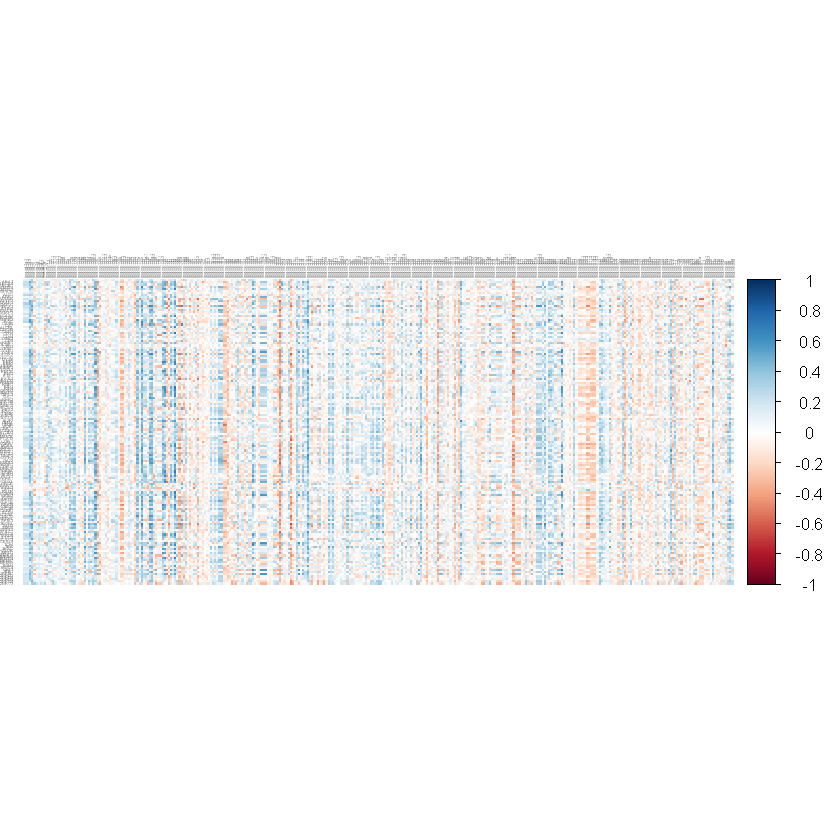

In [72]:
corrplot(result2, method = "color", tl.cex = 0.2, tl.col = "black")

In [73]:
result3 <- apply(result2, 2, function(x) mean(x, na.rm=TRUE))

In [77]:
min(result3)

[1] -0.367236

In [80]:
result3[result3<(-0.2)]

hsa.mir.1266 hsa.mir.129.1 hsa.mir.129.2  hsa.mir.146a   hsa.mir.182 
   -0.2098975    -0.2162047    -0.2190712    -0.2183204    -0.2078968 
  hsa.mir.203    hsa.mir.21   hsa.mir.33b   hsa.mir.34a  hsa.mir.3614 
   -0.3672360    -0.2735295    -0.2269648    -0.3029407    -0.2039569 
  hsa.mir.362  hsa.mir.3934   hsa.mir.589 
   -0.2160078    -0.3069609    -0.2339262

In [89]:
for(i in 1:ncol(result2)-1){
    if(mean(result2[,i+1])>(-0.2)){
        print(1)
        result2 <- result2[,-(i+1)]
    }
}

In [90]:
head(result2)

,hsa.mir.1266,hsa.mir.129.1,hsa.mir.129.2,hsa.mir.146a,hsa.mir.182,hsa.mir.203,hsa.mir.21,hsa.mir.33b,hsa.mir.34a,hsa.mir.3614,hsa.mir.362,hsa.mir.3934,hsa.mir.589
ABAT,-0.09680821,-0.16274614,-0.2170046,-0.05632499,-0.137701537,-0.3239419,-0.3414358,-0.1004420,-0.1811258,-0.11255203,-0.09922783,-0.3048135,-0.06613236
ABCA8,-0.45501734,-0.27074337,-0.2927591,-0.18045205,-0.325875281,-0.5000586,-0.2381011,-0.3126745,-0.4348167,-0.12342876,-0.28810461,-0.4477058,-0.27662167
ABCB1,-0.32169221,-0.07735776,-0.1481108,0.07313344,-0.104160808,-0.2451901,-0.1800771,-0.1529362,-0.2546166,0.07065334,-0.22383530,-0.3072917,-0.20578482
ADAMTS9,-0.14170299,-0.46856048,-0.3896815,-0.37218785,-0.353199991,-0.5571569,-0.4417124,-0.3128942,-0.3000914,-0.30261504,-0.27196991,-0.3355655,-0.24632077
ADAMTSL2,-0.38889670,-0.32944898,-0.3727846,-0.17625141,-0.231246485,-0.3917440,-0.2293190,-0.2408172,-0.2956330,-0.14420088,-0.19060508,-0.4354026,-0.30376476
AGPAT5,-0.14538808,-0.16483880,-0.1829532,-0.17735283,-0.007674822,-0.2814551,-0.1848167,-0.2051199,-0.1553302,-0.16196748,-0.04404528,-0.1033054,-0.04244001


In [119]:
png(file="corr.png", res=300, width = 640, height = 2560)

corrplot(result2, method = "color", tl.cex = 0.3, tl.col = "black", cl.cex = 0.5)

dev.off()

png 
  2